# Merging data and regression analysis

* importing vehicle data and nitrogen data as preprocessed pandas dataframes
* creating columns to merge on as well as mergin
* applying linear and non linear regression models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
%matplotlib inline

#### Load vehicle dataset

In [2]:
df = pd.read_pickle("kfz_data.pkl")

#### Load nitrogen dataset

In [3]:
stickstoff = pd.read_pickle("stickstoff_daten.pkl")

To merge both datasets a shared column must be created. Our goal is to match vehicles registered in certain locations with the nitrogen measured in the air in that specific region. As well as be able to seperate the data by years.

* compare vehicle "ort" values with nitrogen "name"

In [4]:
df.head()

,jahr,bundesland,rb,Stadt,Insgesamt,Benzin,Diesel,kennzahl,ort,split
0,2012,SCHLESWIG-HOLSTEIN,,"01001 FLENSBURG,STADT",39433,26375,12601,01001,"FLENSBURG,STADT",FLENSBURG
1,2012,SCHLESWIG-HOLSTEIN,,"01002 KIEL,STADT",99724,71185,27538,01002,"KIEL,STADT",KIEL
2,2012,SCHLESWIG-HOLSTEIN,,"01003 LUEBECK,STADT",89654,65879,22799,01003,"LUEBECK,STADT",LUEBECK
3,2012,SCHLESWIG-HOLSTEIN,,"01004 NEUMUENSTER,STADT",37974,27051,10435,01004,"NEUMUENSTER,STADT",NEUMUENSTER
4,2012,SCHLESWIG-HOLSTEIN,,01051 DITHMARSCHEN,72836,48921,23173,01051,DITHMARSCHEN,DITHMARSCHEN


In [5]:
stickstoff.head()

,bundesland,jahr,station,name,umgebungstyp,emissionstyp,jahresmittel,maxstundenwert,umgebungstyp_grob
0,BRANDENBURG,2002,'DEBB001',BURG (SPREEWALD),vorstädtisches Gebiet,Hintergrund,10.0,69,vorstädtisch
1,BRANDENBURG,2002,'DEBB006',COTTBUS-SÜD,städtisches Gebiet,Hintergrund,19.0,107,städtisch
2,BRANDENBURG,2002,'DEBB009',FORST,vorstädtisches Gebiet,Hintergrund,16.0,83,vorstädtisch
3,BRANDENBURG,2002,'DEBB021',POTSDAM-ZENTRUM,städtisches Gebiet,Hintergrund,21.0,111,städtisch
4,BRANDENBURG,2002,'DEBB024',SENFTENBERG,städtisches Gebiet,Hintergrund,19.0,113,städtisch


"Name" seems to often contain the city name as the first word. "Ort" also often does the same.
By creating a new column containing only the first word of these location data we might be able to match the sets based on location.

* get only first "word" from stickstoff.name and kraftsplit.ort 
* for merging
* try to split by ' ', '-', '/', ',' to always get first word

In [6]:
sticksplit = stickstoff["name"].str.split(" ").str[0].str.split("-").str[0].str.split("/").str[0].str.split(",").str[0]

In [7]:
kraftsplit = df["ort"].str.split(" ").str[0].str.split("-").str[0].str.split("/").str[0].str.split(",").str[0]

* try to match the new series objects sticksplit and kraftsplit
* count matches and non matches

In [8]:
match = 0
no_match = 0
count = 0

isin = False
for index, row in sticksplit.iteritems():
    isin = False
    for index2, row2 in kraftsplit.iteritems():
        if row == row2:
            isin = True
            #print(row, row2)
    if isin:
        match+=1
        count += 1
    else:
        no_match +=1

In [9]:
match

4344

In [10]:
no_match

4341

Repeat the same for the other way around:

In [11]:
match = 0
no_match = 0
count = 0

isin = False
for index, row in kraftsplit.iteritems():
    isin = False
    for index2, row2 in sticksplit.iteritems():
        if row == row2:
            isin = True
            #print(row, row2)
    if isin:
        match+=1
        count += 1
    else:
        no_match +=1

print(match)
print(no_match)

1329
1876


We find that the majority of data from both datasets can be matched by location via the 'split series'.
This will suffice for our analysis, as we are only looking for averages.

In [12]:
sticksplit.head()

0           BURG
1        COTTBUS
2          FORST
3        POTSDAM
4    SENFTENBERG
Name: name, dtype: object

In [13]:
kraftsplit.head()

0       FLENSBURG
1            KIEL
2         LUEBECK
3     NEUMUENSTER
4    DITHMARSCHEN
Name: ort, dtype: object

* Now create new columns in both dataframe for the matching location parameter and call it "split" respectively.

In [14]:
stickstoff["split"] = sticksplit
df["split"] = kraftsplit

* adjust column names so they match across dataframes

In [15]:
df.rename(columns={"land":"bundesland", "year":"jahr"}, inplace=True)
stickstoff["jahr"] = pd.to_numeric(stickstoff["jahr"])

#### Merge data
* 'inner join' dataframes on the columns "jahr", "bundesland", "split"
* all rows will be able to match via "jahr" and "bundesland"
* rows that dont match via "split" will not be included

In [16]:
result = pd.merge(left=stickstoff, right=df, on=["jahr", "bundesland", "split"])

In [17]:
result.shape

(2523, 17)

In [19]:
result.head()

,bundesland,jahr,station,name,umgebungstyp,emissionstyp,jahresmittel,maxstundenwert,umgebungstyp_grob,split,rb,Stadt,Insgesamt,Benzin,Diesel,kennzahl,ort
0,BADEN-WUERTTEMBERG,2012,DEBW076,BADEN-BADEN,vorstädtisches Gebiet,Hintergrund,15.0,0,vorstädtisch,BADEN,KARLSRUHE,"08211 BADEN-BADEN,STADT",31179,21411,9555,08211,"BADEN-BADEN,STADT"
1,BADEN-WUERTTEMBERG,2012,DEBW046,BIBERACH,vorstädtisches Gebiet,Hintergrund,19.0,0,vorstädtisch,BIBERACH,TUEBINGEN,08426 BIBERACH,110593,72949,36744,08426,BIBERACH
2,BADEN-WUERTTEMBERG,2012,DEBW084,FREIBURG,städtisches Gebiet,Hintergrund,19.0,0,städtisch,FREIBURG,FREIBURG,08311 FREIBURG I.BREISG.STADT,85591,56824,27764,08311,FREIBURG I.BREISG.STADT
3,BADEN-WUERTTEMBERG,2012,DEBW122,FREIBURG SCHWARZWALDSTRASSE (V),städtisches Gebiet,Verkehr,65.0,0,städtisch,FREIBURG,FREIBURG,08311 FREIBURG I.BREISG.STADT,85591,56824,27764,08311,FREIBURG I.BREISG.STADT
4,BADEN-WUERTTEMBERG,2012,DEBW127,FREIBURG ZÄHRINGER STRASSE (S),städtisches Gebiet,Verkehr,50.0,---,städtisch,FREIBURG,FREIBURG,08311 FREIBURG I.BREISG.STADT,85591,56824,27764,08311,FREIBURG I.BREISG.STADT


Join seemed to have worked as intended.

Now checking on "umgebunstyp" and "emissionstyp". 
To get informative results those categories should better not be mixed.

In [22]:
result.groupby("umgebungstyp")["umgebungstyp"].count()

umgebungstyp
ländlich Gebiet            13
ländlich regional          48
ländlich stadtnah          39
städtisches Gebiet       2131
vorstädtisches Gebiet     292
Name: umgebungstyp, dtype: int64

In [23]:
result.groupby("emissionstyp")["emissionstyp"].count()

emissionstyp
Hintergrund    1025
Industrie       111
Verkehr        1387
Name: emissionstyp, dtype: int64

"emissionstyp" contains a Verkehr categorie, which we will use for comparisons of NO2 values.

Now creating a DataFrame with only the values relevant for our final analysis:
* "jahr" the year
* "bundesland" country
* "split" location
* "jahresmittel" year avergae NO2 value
* "insgesamt" absolute vehicle number in that location
* "dieselanteil" new column, calculated by diesel total / total

In [24]:
selection = result[result["emissionstyp"] == "Verkehr"]
result_clean = selection[["jahr","bundesland","split","jahresmittel","Insgesamt"]].copy()
result_clean["dieselanteil"] = selection["Diesel"] / selection["Insgesamt"]

In [26]:
result_clean.head()

,jahr,bundesland,split,jahresmittel,Insgesamt,dieselanteil
3,2012,BADEN-WUERTTEMBERG,FREIBURG,65.0,85591,0.324380
4,2012,BADEN-WUERTTEMBERG,FREIBURG,50.0,85591,0.324380
6,2012,BADEN-WUERTTEMBERG,HEIDELBERG,51.0,55499,0.300348
7,2012,BADEN-WUERTTEMBERG,HEIDENHEIM,53.0,73503,0.299321
10,2012,BADEN-WUERTTEMBERG,KARLSRUHE,46.0,131995,0.312035


* Adding a "location" column, that combined bundesland with split, to achieve a unique location code. 
  (This may help differentiate between e.g. Frankfurt a.M. and Frankfurt Oder )

In [27]:
result_clean["location"] = result_clean["bundesland"] + " " + result_clean["split"]

In [29]:
result_clean["location"].head()

3       BADEN-WUERTTEMBERG FREIBURG
4       BADEN-WUERTTEMBERG FREIBURG
6     BADEN-WUERTTEMBERG HEIDELBERG
7     BADEN-WUERTTEMBERG HEIDENHEIM
10     BADEN-WUERTTEMBERG KARLSRUHE
Name: location, dtype: object

In [30]:
result_clean["jahresmittel"].unique()

array([  65.,   50.,   51.,   53.,   46.,   61.,   79.,   90.,   91.,
         64.,   58.,   39.,   33.,   32.,   34.,   27.,   44.,   26.,
         47.,   45.,   57.,   62.,   49.,   60.,   22.,   42.,   59.,
         55.,   36.,   52.,   43.,   37.,   54.,   41.,   40.,   56.,
         31.,   24.,   30.,   35.,   29.,   48.,   23.,   63.,   38.,
         28.,   72.,   89.,   80.,   25.,   66.,   21.,   20.,   67.,
         71.,   77.,   70.,   87., -999.,   82.,   76.,   19.,   73.,
         69.,   18.,   17.,   16.])

* there still is a <0 value that was not properly removed
* remove all <0 Values

In [31]:
result_clean = result_clean[result_clean["jahresmittel"] > 0]

Creating individual sub-DFs for easy acces of the individual year data.

In [33]:
years = [2012,2013,2014,2015,2016,2017,2018,2019]
year_df = []
for year in years:
    year_df.append(result_clean[result_clean["jahr"] == year])

Via groupby and mean we calculate the mean values of nitrogen, vehicles total and diesel percentage for each location.
This is averaged over all years. 

In [34]:
sum_no2 = result_clean.groupby("location")[["jahresmittel","Insgesamt", "dieselanteil"]].mean()

In [36]:
sum_no2.head()

,jahresmittel,Insgesamt,dieselanteil
location,,,
BADEN-WUERTTEMBERG ESSLINGEN,46.500000,322083.750000,0.328483
BADEN-WUERTTEMBERG FREIBURG,49.153846,88447.384615,0.352220
BADEN-WUERTTEMBERG HEIDELBERG,42.375000,58094.125000,0.333817
BADEN-WUERTTEMBERG HEIDENHEIM,45.000000,77546.250000,0.327444
BADEN-WUERTTEMBERG HEILBRONN,57.714286,143025.928571,0.337812


In [37]:
# may be saved as csv
#sum_no2.to_csv("sum_no2.csv")

* Visualizing NO2 values against total vehicles in any location

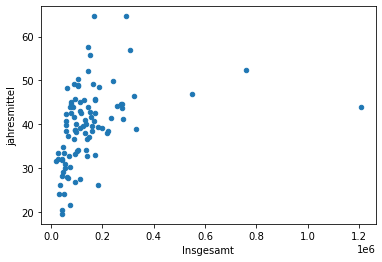

In [38]:
sum_no2.plot(x="Insgesamt", y="jahresmittel",kind="scatter")

* Dropping extreme outliers. Those may occur due to major car sharing companies.

In [41]:
sum_no2 = sum_no2[sum_no2["Insgesamt"] < 400000]

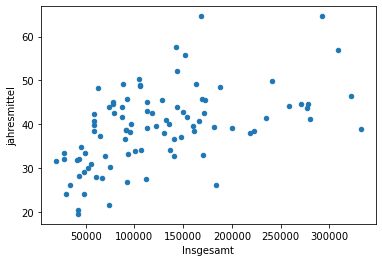

In [42]:
sum_no2.plot(x="Insgesamt", y="jahresmittel",kind="scatter")

In [43]:
sum_no2.corr()

,jahresmittel,Insgesamt,dieselanteil
jahresmittel,1.000000,0.513440,0.205867
Insgesamt,0.513440,1.000000,0.139262
dieselanteil,0.205867,0.139262,1.000000


Positive correlation between car total and NO2 values is visible.

Dieselanteil doesnt correlate strongly with NO2 values, however, plotting for a visual impression.

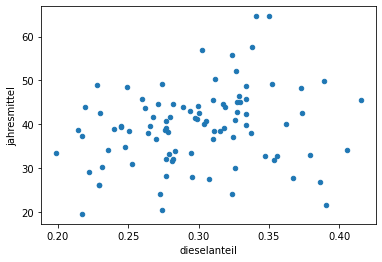

In [44]:
sum_no2.plot(x="dieselanteil", y="jahresmittel",kind="scatter")

#### Linear Regression

* try to fit a linear regression model for vehicles total vs NO2 values
* as well as dieselanteil vs NO2 values
* using sklear model

In [48]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
# turning series to np array
train_x = sum_no2["Insgesamt"].values.reshape(-1, 1)
train_y = sum_no2["jahresmittel"].values.reshape(-1, 1)
regr.fit (train_x, train_y)

LinearRegression()

Plot the resulting regression 'curve' onto the data.

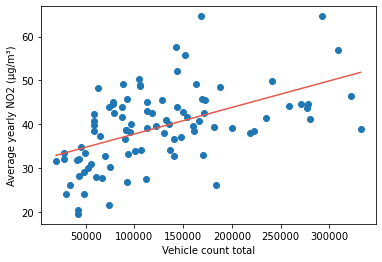

In [51]:
plt.scatter(train_x, train_y)

vals = np.arange(min(train_x),max(train_x)).reshape(-1,1)
plt.plot(vals, regr.predict(vals), color=(227/255, 89/255, 79/255))

plt.xlabel("Vehicle count total")
plt.ylabel("Average yearly NO2 (µg/m³)")
plt.show()

Get error values.

In [52]:
from sklearn.metrics import r2_score
train_y_ = regr.predict(train_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(train_y_ - train_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((train_y_ - train_y) ** 2))
print("R2-score: %.2f" % r2_score(train_y, train_y_) )

Mean absolute error: 6.00
Residual sum of squares (MSE): 56.78
R2-score: 0.26


R² is not very high, however we also have very highly deviating data.

Repeat for dieselanteil.

In [57]:
regr = linear_model.LinearRegression()
train_x = sum_no2["dieselanteil"].values.reshape(-1, 1)
train_y = sum_no2["jahresmittel"].values.reshape(-1, 1)
regr.fit (train_x, train_y)

LinearRegression()

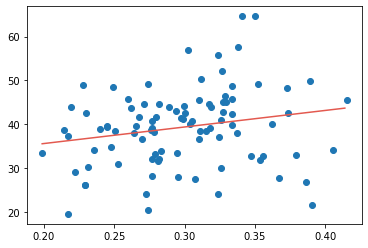

In [60]:
plt.scatter(train_x, train_y)
vals = np.arange(min(train_x),max(train_x), step=0.005).reshape(-1,1)
plt.plot(vals, regr.predict(vals), color=(227/255, 89/255, 79/255))
plt.show()

Receive line with positive slope, however not as steep.

* get errors as well

In [62]:
from sklearn.metrics import r2_score

train_y_ = regr.predict(train_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(train_y_ - train_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((train_y_ - train_y) ** 2))
print("R2-score: %.2f" % r2_score(train_y, train_y_) )

Mean absolute error: 6.61
Residual sum of squares (MSE): 73.85
R2-score: 0.04


* very low R² score

Compute heatmaps of given data to visualise missing data as well as potential trends over the years.

year_df contains the previously obtained single year dataframes.

In [64]:
year_df[0].head()

,jahr,bundesland,split,jahresmittel,Insgesamt,dieselanteil,location
3,2012,BADEN-WUERTTEMBERG,FREIBURG,65.0,85591,0.324380,BADEN-WUERTTEMBERG FREIBURG
4,2012,BADEN-WUERTTEMBERG,FREIBURG,50.0,85591,0.324380,BADEN-WUERTTEMBERG FREIBURG
6,2012,BADEN-WUERTTEMBERG,HEIDELBERG,51.0,55499,0.300348,BADEN-WUERTTEMBERG HEIDELBERG
7,2012,BADEN-WUERTTEMBERG,HEIDENHEIM,53.0,73503,0.299321,BADEN-WUERTTEMBERG HEIDENHEIM
10,2012,BADEN-WUERTTEMBERG,KARLSRUHE,46.0,131995,0.312035,BADEN-WUERTTEMBERG KARLSRUHE


Aggregate single year dataframes for location and get mean values.

In [65]:
grouped = []
for x in year_df:
    grouped.append(x.groupby("location")[["jahresmittel","Insgesamt", "dieselanteil"]].mean())

In [67]:
grouped[0].head()

,jahresmittel,Insgesamt,dieselanteil
location,,,
BADEN-WUERTTEMBERG FREIBURG,57.5,85591.0,0.324380
BADEN-WUERTTEMBERG HEIDELBERG,51.0,55499.0,0.300348
BADEN-WUERTTEMBERG HEIDENHEIM,53.0,73503.0,0.299321
BADEN-WUERTTEMBERG KARLSRUHE,46.0,189694.0,0.294489
BADEN-WUERTTEMBERG LUDWIGSBURG,61.0,292479.0,0.277097


Create heatmap dataframe, for visualisation of the change in vehicles total as well as NO2 values over several years in each location. This will also highlight data missing for cetain years.

In [68]:
heatmap = pd.DataFrame(index=grouped[0].index)
for id,year in enumerate(years):
    heatmap[str(year)] = grouped[id]["jahresmittel"]

In [70]:
heatmap.head()

,2012,2013,2014,2015,2016,2017,2018,2019
location,,,,,,,,
BADEN-WUERTTEMBERG FREIBURG,57.5,54.5,52.5,48.5,41.0,43.0,50.0,36.0
BADEN-WUERTTEMBERG HEIDELBERG,51.0,46.0,44.0,45.0,42.0,39.0,38.0,34.0
BADEN-WUERTTEMBERG HEIDENHEIM,53.0,50.0,49.0,48.0,44.0,41.0,39.0,36.0
BADEN-WUERTTEMBERG KARLSRUHE,46.0,39.0,NaN,NaN,NaN,39.0,38.0,34.0
BADEN-WUERTTEMBERG LUDWIGSBURG,61.0,64.0,61.0,58.0,53.0,51.0,51.0,NaN


In [71]:
import seaborn as sns

Visualising heatmap for NO2 values. X-axis only shows example subset of locations.

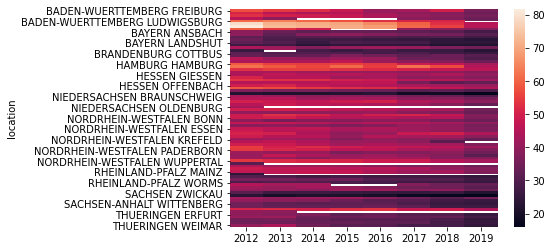

In [72]:
sns.heatmap(heatmap, annot=False)

* For some some locations NO2 values may be decresing over the years.

In [74]:
heatmap = pd.DataFrame(index=grouped[0].index)
for id,year in enumerate(years):
    heatmap[str(year)] = grouped[id]["Insgesamt"]

Visualising heatmap for total vehicle values. X-axis only shows example subset of locations.

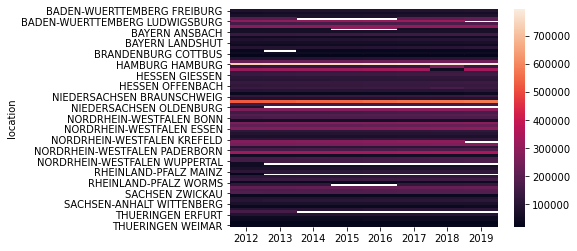

In [75]:
sns.heatmap(heatmap, annot=False)

* Toal vehicle numbers don't seem to change much over years.

Missing values in both these Heatmaps may result from NO2 measure stations being created/removed as well as car registration offices may be opened and closed.

### Nonlinear regression

Try to fit polynomials with degree 2 to 8 on our data.
* attempting to find best fit via lasso with crossvalidation (lassocv)
* Use MSE for comparison.

In [76]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline

In [95]:
#potential lasso parameters

#eps = 0.0001
#nalpha=20
#iter=5000

In [96]:
degree_min = 2
degree_max = 8

In [97]:
# turn to numpy arrays
x = sum_no2["Insgesamt"].values.reshape(-1, 1)
y = sum_no2["jahresmittel"].values.reshape(-1, 1)

* create model of Polynomial features with lasso regression
* fit models to our data
* save model error, score and model

In [98]:
# just for notebook readability dont show module warnings
import warnings
warnings.filterwarnings('ignore')

* for each degree from 2 to 8:
* create polynomial features and apply lassocv
* fit Lasso model
* save in list

In [116]:
results = []
for degree in range(degree_min,degree_max+1):
    model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), LassoCV(normalize=True,cv=5))
    model.fit(x,y)
    results.append(model)

In [81]:
# Alternative for ridge regression. Will receive better errors, but also more prone to overfitting.

"""from sklearn.linear_model import Ridge
results = []
for degree in range(degree_min,degree_max+1):
    model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), Ridge())
    model.fit(x,y)
    results.append(model)"""

'from sklearn.linear_model import Ridge\nresults = []\nfor degree in range(degree_min,degree_max+1):\n    model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), Ridge())\n    model.fit(x,y)\n    results.append(model)'

Plot all resulting plots of fitted polynomials and calculate errors.

#### Plot for each polynomial degree

Text(0, 0.5, 'Jahresmittel NO2')

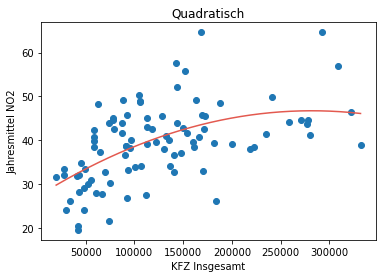

In [117]:
vals = np.arange(min(x),max(x)).reshape(-1,1)
plt.plot(vals, results[0].predict(vals), color=(227/255, 89/255, 79/255))#, s=0.001)
plt.scatter(x,y)
plt.title("Quadratisch")
plt.xlabel("KFZ Insgesamt")
plt.ylabel("Jahresmittel NO2")

In [230]:
print("Mean absolute error: %.2f" % np.mean(np.absolute(results[0].predict(x) - y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((results[0].predict(x) - y) ** 2))

Mean absolute error: 7.85
Residual sum of squares (MSE): 99.54


Text(0, 0.5, 'Jahresmittel NO2')

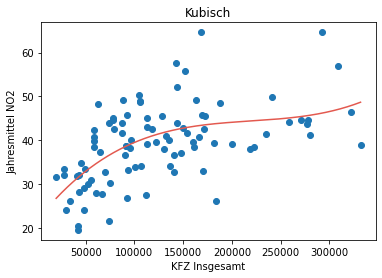

In [119]:
plt.plot(vals, results[1].predict(vals), color=(227/255, 89/255, 79/255))#, s=0.001)
plt.scatter(x,y)
plt.title("Kubisch")
plt.xlabel("KFZ Insgesamt")
plt.ylabel("Jahresmittel NO2")

In [231]:
print("Mean absolute error: %.2f" % np.mean(np.absolute(results[1].predict(x) - y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((results[1].predict(x) - y) ** 2))

Mean absolute error: 7.91
Residual sum of squares (MSE): 101.89


Text(0, 0.5, 'Jahresmittel NO2')

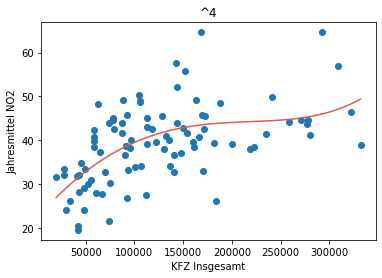

In [121]:
plt.plot(vals, results[2].predict(vals), color=(227/255, 89/255, 79/255))#, s=0.001)
plt.scatter(x,y)
plt.title("^4")
plt.xlabel("KFZ Insgesamt")
plt.ylabel("Jahresmittel NO2")

In [232]:
print("Mean absolute error: %.2f" % np.mean(np.absolute(results[2].predict(x) - y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((results[2].predict(x) - y) ** 2))

Mean absolute error: 7.91
Residual sum of squares (MSE): 102.05


Text(0, 0.5, 'Jahresmittel NO2')

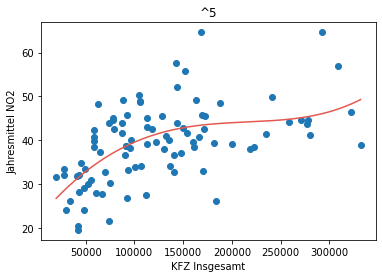

In [123]:
plt.plot(vals, results[3].predict(vals), color=(227/255, 89/255, 79/255))#, s=0.001)
plt.scatter(x,y)
plt.title("^5")
plt.xlabel("KFZ Insgesamt")
plt.ylabel("Jahresmittel NO2")

In [233]:
print("Mean absolute error: %.2f" % np.mean(np.absolute(results[3].predict(x) - y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((results[3].predict(x) - y) ** 2))

Mean absolute error: 7.91
Residual sum of squares (MSE): 102.14


Text(0, 0.5, 'Jahresmittel NO2')

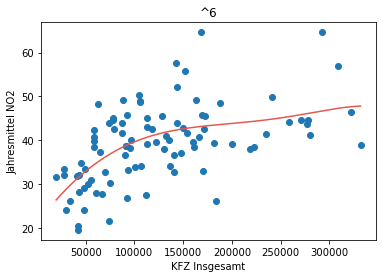

In [125]:
plt.plot(vals, results[4].predict(vals), color=(227/255, 89/255, 79/255))#, s=0.001)
plt.scatter(x,y)
plt.title("^6")
plt.xlabel("KFZ Insgesamt")
plt.ylabel("Jahresmittel NO2")

In [234]:
print("Mean absolute error: %.2f" % np.mean(np.absolute(results[4].predict(x) - y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((results[4].predict(x) - y) ** 2))

Mean absolute error: 7.90
Residual sum of squares (MSE): 101.90


Text(0, 0.5, 'Jahresmittel NO2')

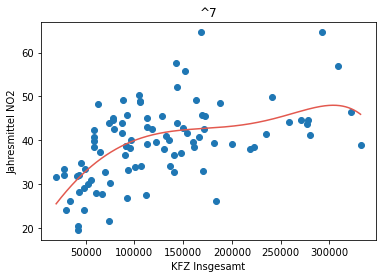

In [127]:
plt.plot(vals, results[5].predict(vals), color=(227/255, 89/255, 79/255))#, s=0.001)
plt.scatter(x,y)
plt.title("^7")
plt.xlabel("KFZ Insgesamt")
plt.ylabel("Jahresmittel NO2")

In [235]:
print("Mean absolute error: %.2f" % np.mean(np.absolute(results[5].predict(x) - y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((results[5].predict(x) - y) ** 2))

Mean absolute error: 7.91
Residual sum of squares (MSE): 102.42


Text(0, 0.5, 'Jahresmittel NO2')

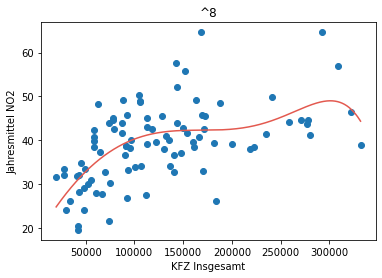

In [129]:
plt.plot(vals, results[6].predict(vals), color=(227/255, 89/255, 79/255))#, s=0.001)
plt.scatter(x,y)
plt.title("^8")
plt.xlabel("KFZ Insgesamt")
plt.ylabel("Jahresmittel NO2")

In [236]:
print("Mean absolute error: %.2f" % np.mean(np.absolute(results[6].predict(x) - y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((results[6].predict(x) - y) ** 2))

Mean absolute error: 7.94
Residual sum of squares (MSE): 103.38


While ridge regression achieves better MSE scores on the data fit, lasso regression may reduce overfitting.
* lowest MSE is achieved by quadratic polynomial

Thinking about the problem, most polynomials don't seem to fit the question very well. As e.g. the best fit quadratic polynomial would result in lower NO2 values for very high vehicle counts. Ending on a positive slope with another polynomial would also not be logical.

One theory is, that a log curve would well describe the data, as streets do have a max capacity, so even with more vehicles registered, there may not be more vehicles driving at the same time. 

Following: Fitting of log funktion to data

In [203]:
from scipy import optimize
def f(x, a, b):
    return a * np.log(x * b)

In [204]:
params, params_covariance = optimize.curve_fit(f, sum_no2["Insgesamt"], sum_no2["jahresmittel"])

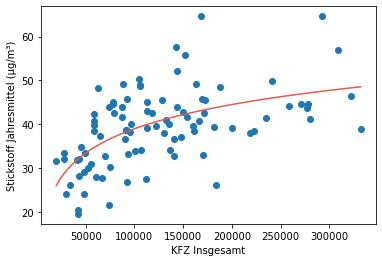

In [240]:
plt.scatter(sum_no2["Insgesamt"], sum_no2["jahresmittel"])
plt.plot(vals, f(vals, params[0], params[1]), color=(227/255, 89/255, 79/255))
plt.xlabel("KFZ Insgesamt")
plt.ylabel("Stickstoff Jahresmittel (μg/m³)")
#plt.savefig("log_curve_fit.png")

In [237]:
vals_log = f(x, params[0], params[1])

In [238]:
print("Mean absolute error: %.2f" % np.mean(np.absolute(vals_log - y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((vals_log - y) ** 2))

Mean absolute error: 5.73
Residual sum of squares (MSE): 52.11
